## This notebook allows individual cells to be cropped, and the DFI values obtained

- a final set of cropped images with DFI labels is provided here: https://figshare.com/articles/Deep_learning-based_selection_of_human_sperm_with_high_DNA_integrity/8124932
    

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

import datetime
from shutil import copyfile

now = datetime.datetime.now()
todays_date = (now.strftime('%Y%m%d%H%M'))

'''
1. change the path to load image and store data 
3. images should be named as BF#.tif with \
            corresponding Red/Green#.tif
4. click a lot
5. 'draw a line' (no line visible) from the front of the head to the back
    5ai. click and hold the tip of the head
    5aii. drag cursor to the back of head
    5aiii. release left mouse buttom
    
5b. do this for each sperm in brightfield image
6. click 'n' when done with image
6b. now new image pops up, click some more then click 'n' again
7. after it goes through all images, if it doesn't find the next one, it quits
9. I think that's it, the algo with rotate and crop all images
9b. check progress as it goes, pretty easy to see if you messed up
10. manually check each image (brightfield and fluorescence) 
    to make sure images are ok
11. put good images in new folder
'''

# set image and data path here of images to read
pwd = os.getcwd()
path = os.path.join(pwd,'01_renamed_and_sorted_large_tifs')

## set whether or not to just read latest csv file for image locations
read_saved = False # should we use saved pkl files with all stored coordinates?
make_imgs = True # do we want to extract crops?

print('looking at %s and %s reading saved pkls and %s creating new images' %
     (path, read_saved, make_imgs))
if read_saved:
    all_pkl_files = [f for f in os.listdir(pwd) \
                     if os.path.splitext(os.path.join(pwd,f))[1] == '.pkl']

    print(all_pkl_files,'\n')
    
    image_coords_file = all_pkl_files[-3]
    scale_coords_file = all_pkl_files[-2]
    DFI_good_bad_file = all_pkl_files[-1]
    
    print('img coords: %s \n scale coords: %s \n DFI: %s' %
          (image_coords_file, scale_coords_file, DFI_good_bad_file))
    
if make_imgs:
    # set image and data path here of images to write
    path_write = os.path.join(pwd,todays_date + '_output_images')
    if not os.path.exists(path_write):
        os.makedirs(path_write)

    path_write_good = os.path.join(pwd,todays_date + '_output_images_good')
    if not os.path.exists(path_write_good):
        os.makedirs(path_write_good)

# create button press event log functions

points = []

# EVENT_LBUTTONDOWN 
# EVENT_LBUTTONUP 

def mouseCB(event,x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append([x, y])
    if event == cv2.EVENT_LBUTTONUP:
        points.append([x, y])
        
def mouseDBL(event,x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDBLCLK :
        print (x, y)
        points.append([x, y])

looking at D:\Dropbox (SintonLab)\Personal Folders\Chris\paper_drafts\20180509_deep_learning_from_DFI_paper\Chris_DFI_paper\all_code\01_renamed_and_sorted_large_tifs and False reading saved pkls and True creating new images


In [2]:
# go through each image and manually select each sperm cell

if not read_saved:
    count = 0

    exit_flag = True

    points_list = []

    while exit_flag:
        window_name = 'image_' + str(count)
        cv2.namedWindow(window_name)
        cv2.setMouseCallback(window_name, mouseCB)

        image_name = 'BF' + str(count) + '.tif'
        image_path = os.path.join(path, image_name)
        print(image_path)

        if not os.path.isfile(image_path):
            print('image not found')
            break

        img = cv2.imread(image_path)
        img_size = img.shape
        img2 = cv2.resize(img, (img_size[1]//2,img_size[0]//2))   
        img3 = cv2.normalize(img2, np.zeros_like(img2), 0, 255, cv2.NORM_MINMAX)
        cv2.imshow(window_name, img3)

        while True:
            ip = cv2.waitKey(0) & 0xFF
            if ip == ord('n'):
                count += 1
                points_list.append(points)
                points = []
                cv2.destroyAllWindows()
                break
            elif ip == ord('q'):
                exit_flag = False
                break
        print(count)
        total_count = count

    data = {'img_coords': np.asarray(points_list).tolist()}
    file = os.path.join(pwd, todays_date + '_image_coords.pkl')

    df = pd.DataFrame.from_dict(data)
    df.to_pickle(file)


    cv2.destroyAllWindows()

D:\Dropbox (SintonLab)\Personal Folders\Chris\paper_drafts\20180509_deep_learning_from_DFI_paper\Chris_DFI_paper\all_code\01_renamed_and_sorted_large_tifs\BF0.tif
1
D:\Dropbox (SintonLab)\Personal Folders\Chris\paper_drafts\20180509_deep_learning_from_DFI_paper\Chris_DFI_paper\all_code\01_renamed_and_sorted_large_tifs\BF1.tif
image not found


In [3]:
if read_saved:
    df = pd.read_pickle(image_coords_file)
    points_list = df['img_coords'].values

#     df2 = pd.read_pickle(scale_coords_file)
#     scale_list = df2['scale_coords'].values
    
    if not make_imgs:
        df3 = pd.read_pickle(DFI_good_bad_file)
        DFI_list = df3['DFI_list'].values
        good_list = df3['good_list'].values
        bad_list = df3['bad_list'].values

D:\Dropbox (SintonLab)\Personal Folders\Chris\paper_drafts\20180509_deep_learning_from_DFI_paper\Chris_DFI_paper\all_code\01_renamed_and_sorted_large_tifs\BF0.tif


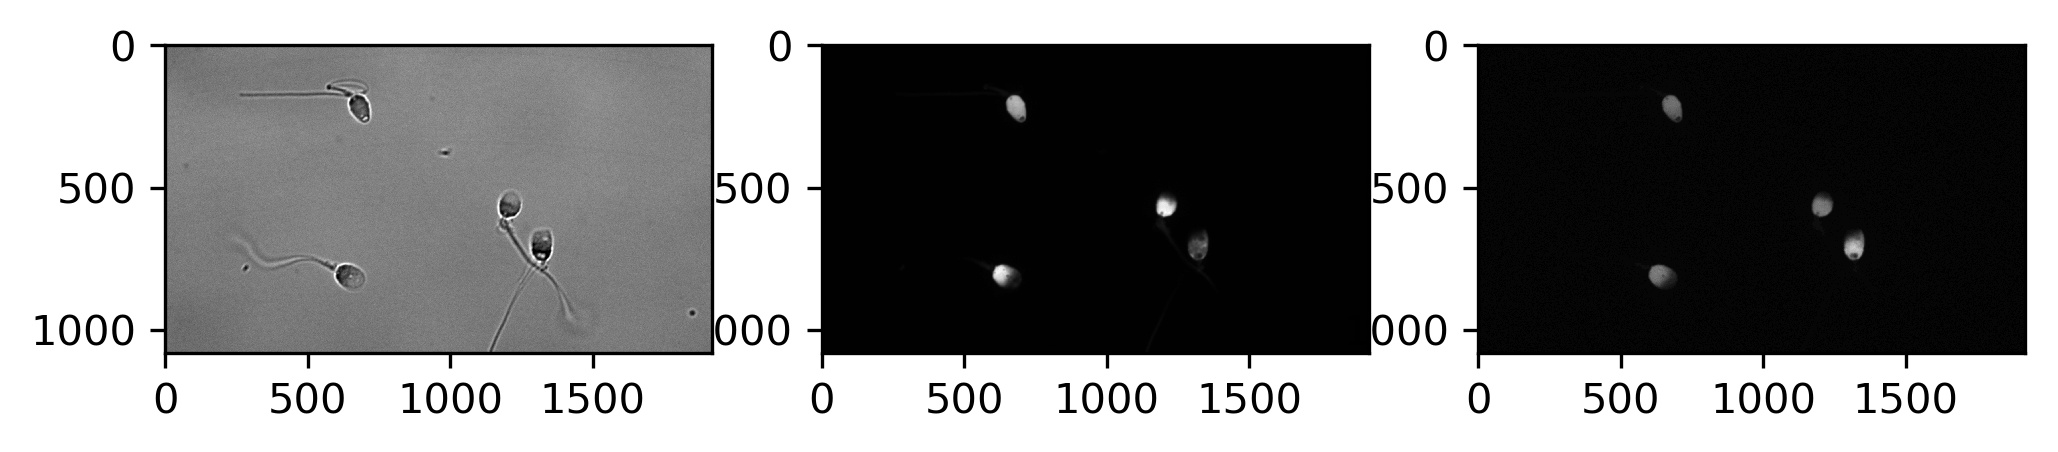

708 662 274 174
65.2975697722287


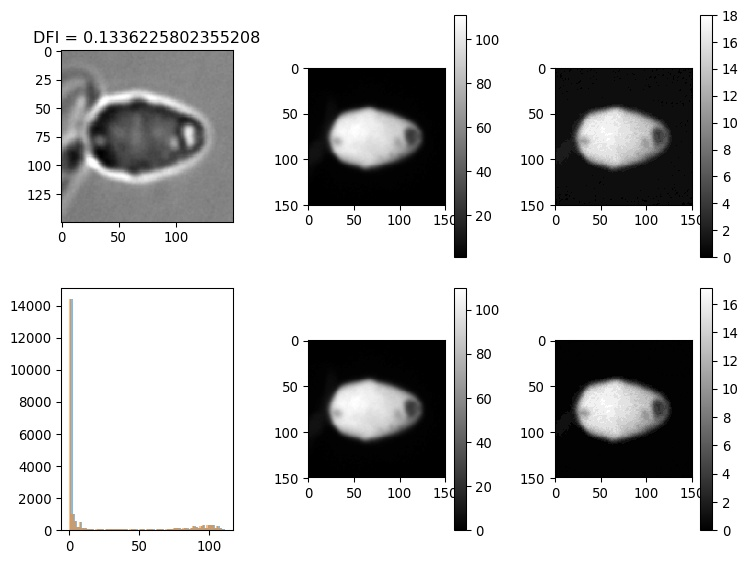

702 602 838 782
29.248826336546976
1230 1194 510 602
-68.62937773065681
1322 1326 650 760
267.9174347202691


In [5]:
if (make_imgs):
    cv2.destroyAllWindows()
    big_iter = 0
    DFI_list = []
    good_list = []
    bad_list = []
    plot_ellipse = True

    for i in range(0,len(points_list)):
        count = i

        ## --------- DIC img
        image_name = 'BF' + str(count) + '.tif'
        image_path = os.path.join(path, image_name)
        print(image_path)

        img = cv2.imread(image_path,0)
        rows,cols = img.shape

        ## --------- fluorescent img1
        image_nameFL = 'Green' + str(count) + '.tif'
        image_pathFL = os.path.join(path, image_nameFL)
        imgFLa = cv2.imread(image_pathFL,0)
        rowsFL,colsFL = imgFLa.shape

        imgFLc = imgFLa

        ## --------- fluorescent img2
        image_nameFL2 = 'Red' + str(count) + '.tif'
        image_pathFL2 = os.path.join(path, image_nameFL2)
        imgFL2a = cv2.imread(image_pathFL2,0)

        imgFL2c = imgFL2a
    
        plt.figure(figsize=(8,6),dpi=300)
        plt.gray()
        plt.subplot(1,3,2), plt.imshow(imgFLc)
        plt.subplot(1,3,3), plt.imshow(imgFL2c)
        plt.subplot(1,3,1), plt.imshow(img)
        plt.show()


        for ii in range(0,len(points_list[i]),2):
            if False:
                start_at_num = 1
                if ii == (len(points_list[i]) - 1):
                    break
            else:
                start_at_num = 0

            x1 = 2*points_list[i][ii+start_at_num][0]
            x2 = 2*points_list[i][ii+1+start_at_num][0]
            y1 = 2*points_list[i][ii+start_at_num][1]
            y2 = 2*points_list[i][ii+1+start_at_num][1]

            flipx=False
            flipy=False
            x1b=x1
            x2b=x2
            y1b=y1
            y2b=y2

            if x2<x1:
                x0 = x1
                x1b = x2
                x2b = x0
                flipx = True
            if y2<y1:
                y0 = y1
                y1b = y2
                y2b = y0
                flipy = True

            if flipx:
                add_180 = 0
            else:
                add_180 = 180

            print(x1,x2,y1,y2)

            if x2==x1 and y2>y1:
                theta = 90
            elif x2==x1 and y1>y2:
                theta = 270
            else:
                theta = np.arctan((y2-y1)/(x2-x1)) * 180 / np.pi + add_180

            rad = theta * np.pi / 180

            dist = np.sqrt((x2-x1)**2 + (y2-y1)**2)

            print(theta)

            new_img_size = 150
            new_img_size_FL = 150

            min_thresh = 50

            M = cv2.getRotationMatrix2D(((x1+x2)/2,(y1+y2)/2),theta,1)
            dst = cv2.warpAffine(img,M,(cols,rows))    
            dst2 = cv2.getRectSubPix(dst,(new_img_size,new_img_size),
                                     ((x1+x2)/2,(y1+y2)/2))

            img_num = '%03d' % (big_iter)
            img_num2 = '%03d' % (ii)

            ## write new images
            dst2_name = 'img' + img_num + '_' + image_name[:-4] + img_num2 + '.jpg'
            cv2.imwrite(os.path.join(path_write,dst2_name),dst2)
            big_iter += 1

            ## fl img1
            dstFLa = cv2.warpAffine(imgFLc,M,(cols,rows)) 
            dstFLb = cv2.getRectSubPix(dstFLa,(new_img_size_FL,new_img_size_FL),
                                       ((x1+x2)/2,(y1+y2)/2))

            ## write new images
            dstFLb_name = 'img' + img_num + '_' + image_nameFL[:-4] + \
            img_num2 + '.jpg'
#             cv2.imwrite(os.path.join(path_write,dstFLb_name),dstFLb)

            hist1, bins1 = np.histogram(dstFLb, bins=64)
            hist1b = hist1[bins1[:-1]<10]
            bins1b = bins1[bins1<10]            
#             bkgr1 = (bins1b[np.argmax(hist1b)] + bins1b[np.argmax(hist1b)+1])/2
            bkgr1 = (bins1b[np.argmax(hist1b)])

            thresh1 = np.asarray(dstFLb)- bkgr1 * np.ones_like(dstFLb)
            thresh1[thresh1<0] = 0

            sum_good = np.sum(thresh1)

            ## fl img2
            dstFL2a = cv2.warpAffine(imgFL2c,M,(cols,rows)) 
            dstFL2b = cv2.getRectSubPix(dstFL2a,(new_img_size_FL,new_img_size_FL),
                                       ((x1+x2)/2,(y1+y2)/2))

            hist2, bins2 = np.histogram(dstFL2b, bins=64)
            hist2b = hist2[bins2[:-1]<10]
            bins2b = bins2[bins2<10]
#             bkgr2 = (bins2b[np.argmax(hist2b)] + bins2b[np.argmax(hist2b)+1])/2
            bkgr2 = (bins2b[np.argmax(hist2b)])
            

            thresh2 = np.asarray(dstFL2b) - bkgr2 * np.ones_like(dstFL2b)
            thresh2[thresh2<0] = 0
            sum_bad = np.sum(thresh2)
            DFI = (sum_bad/(sum_good+sum_bad))

            ## write fluorescence img with DFI value overlay
            thresh1_mod = thresh1.copy()
            cv2.putText(thresh1_mod,'DFI=%.3f' % DFI, (5,15), 
                        cv2.FONT_HERSHEY_SIMPLEX, .5, 
                        np.max(thresh1_mod),1,cv2.LINE_AA)
            cv2.normalize(thresh1_mod,thresh1_mod,0,255,cv2.NORM_MINMAX)
            cv2.imwrite(os.path.join(path_write,dstFLb_name),thresh1_mod)
            
            ## add values to list
            DFI_list.append(DFI)
            good_list.append(sum_good)
            bad_list.append(sum_bad)

            if ii==0:
                plt.figure(figsize=(8,6),dpi=96)
                plt.gray()
                plt.subplot(2,3,1), plt.imshow(dst2)
                plt.title('DFI = %s' % DFI)
                plt.subplot(2,3,2), plt.imshow(dstFLb)
                plt.colorbar()
                plt.subplot(2,3,3), plt.imshow(dstFL2b)
                plt.colorbar()
                plt.subplot(2,3,5), plt.imshow(thresh1)
                plt.colorbar()
                plt.subplot(2,3,6), plt.imshow(thresh2)
                plt.colorbar() 
                plt.subplot(2,3,4)
                plt.hist(dstFLb.flatten(), bins=64, alpha=0.5)
                plt.hist(thresh1.flatten(), bins=64, alpha=0.5)
                plt.tight_layout()
                plt.show()

    data3 = {'DFI_list': np.asarray(DFI_list).tolist()}
    data3['good_list'] = np.asarray(good_list).tolist()
    data3['bad_list'] = np.asarray(bad_list).tolist()

    file3 = os.path.join(pwd, todays_date + '_DFI_good_bad.pkl')

    df3 = pd.DataFrame.from_dict(data3)
    df3.to_pickle(file3)

In [10]:
img_name_list = []
for i in range(0,len(points_list)):
        count = i
        ## --------- DIC img
        image_name = 'BF' + str(count)
        
        for ii in range(0,len(points_list[i]),2):
                
            img_name_list.append(image_name)
            

## plot DFI values and green/red fluorescence

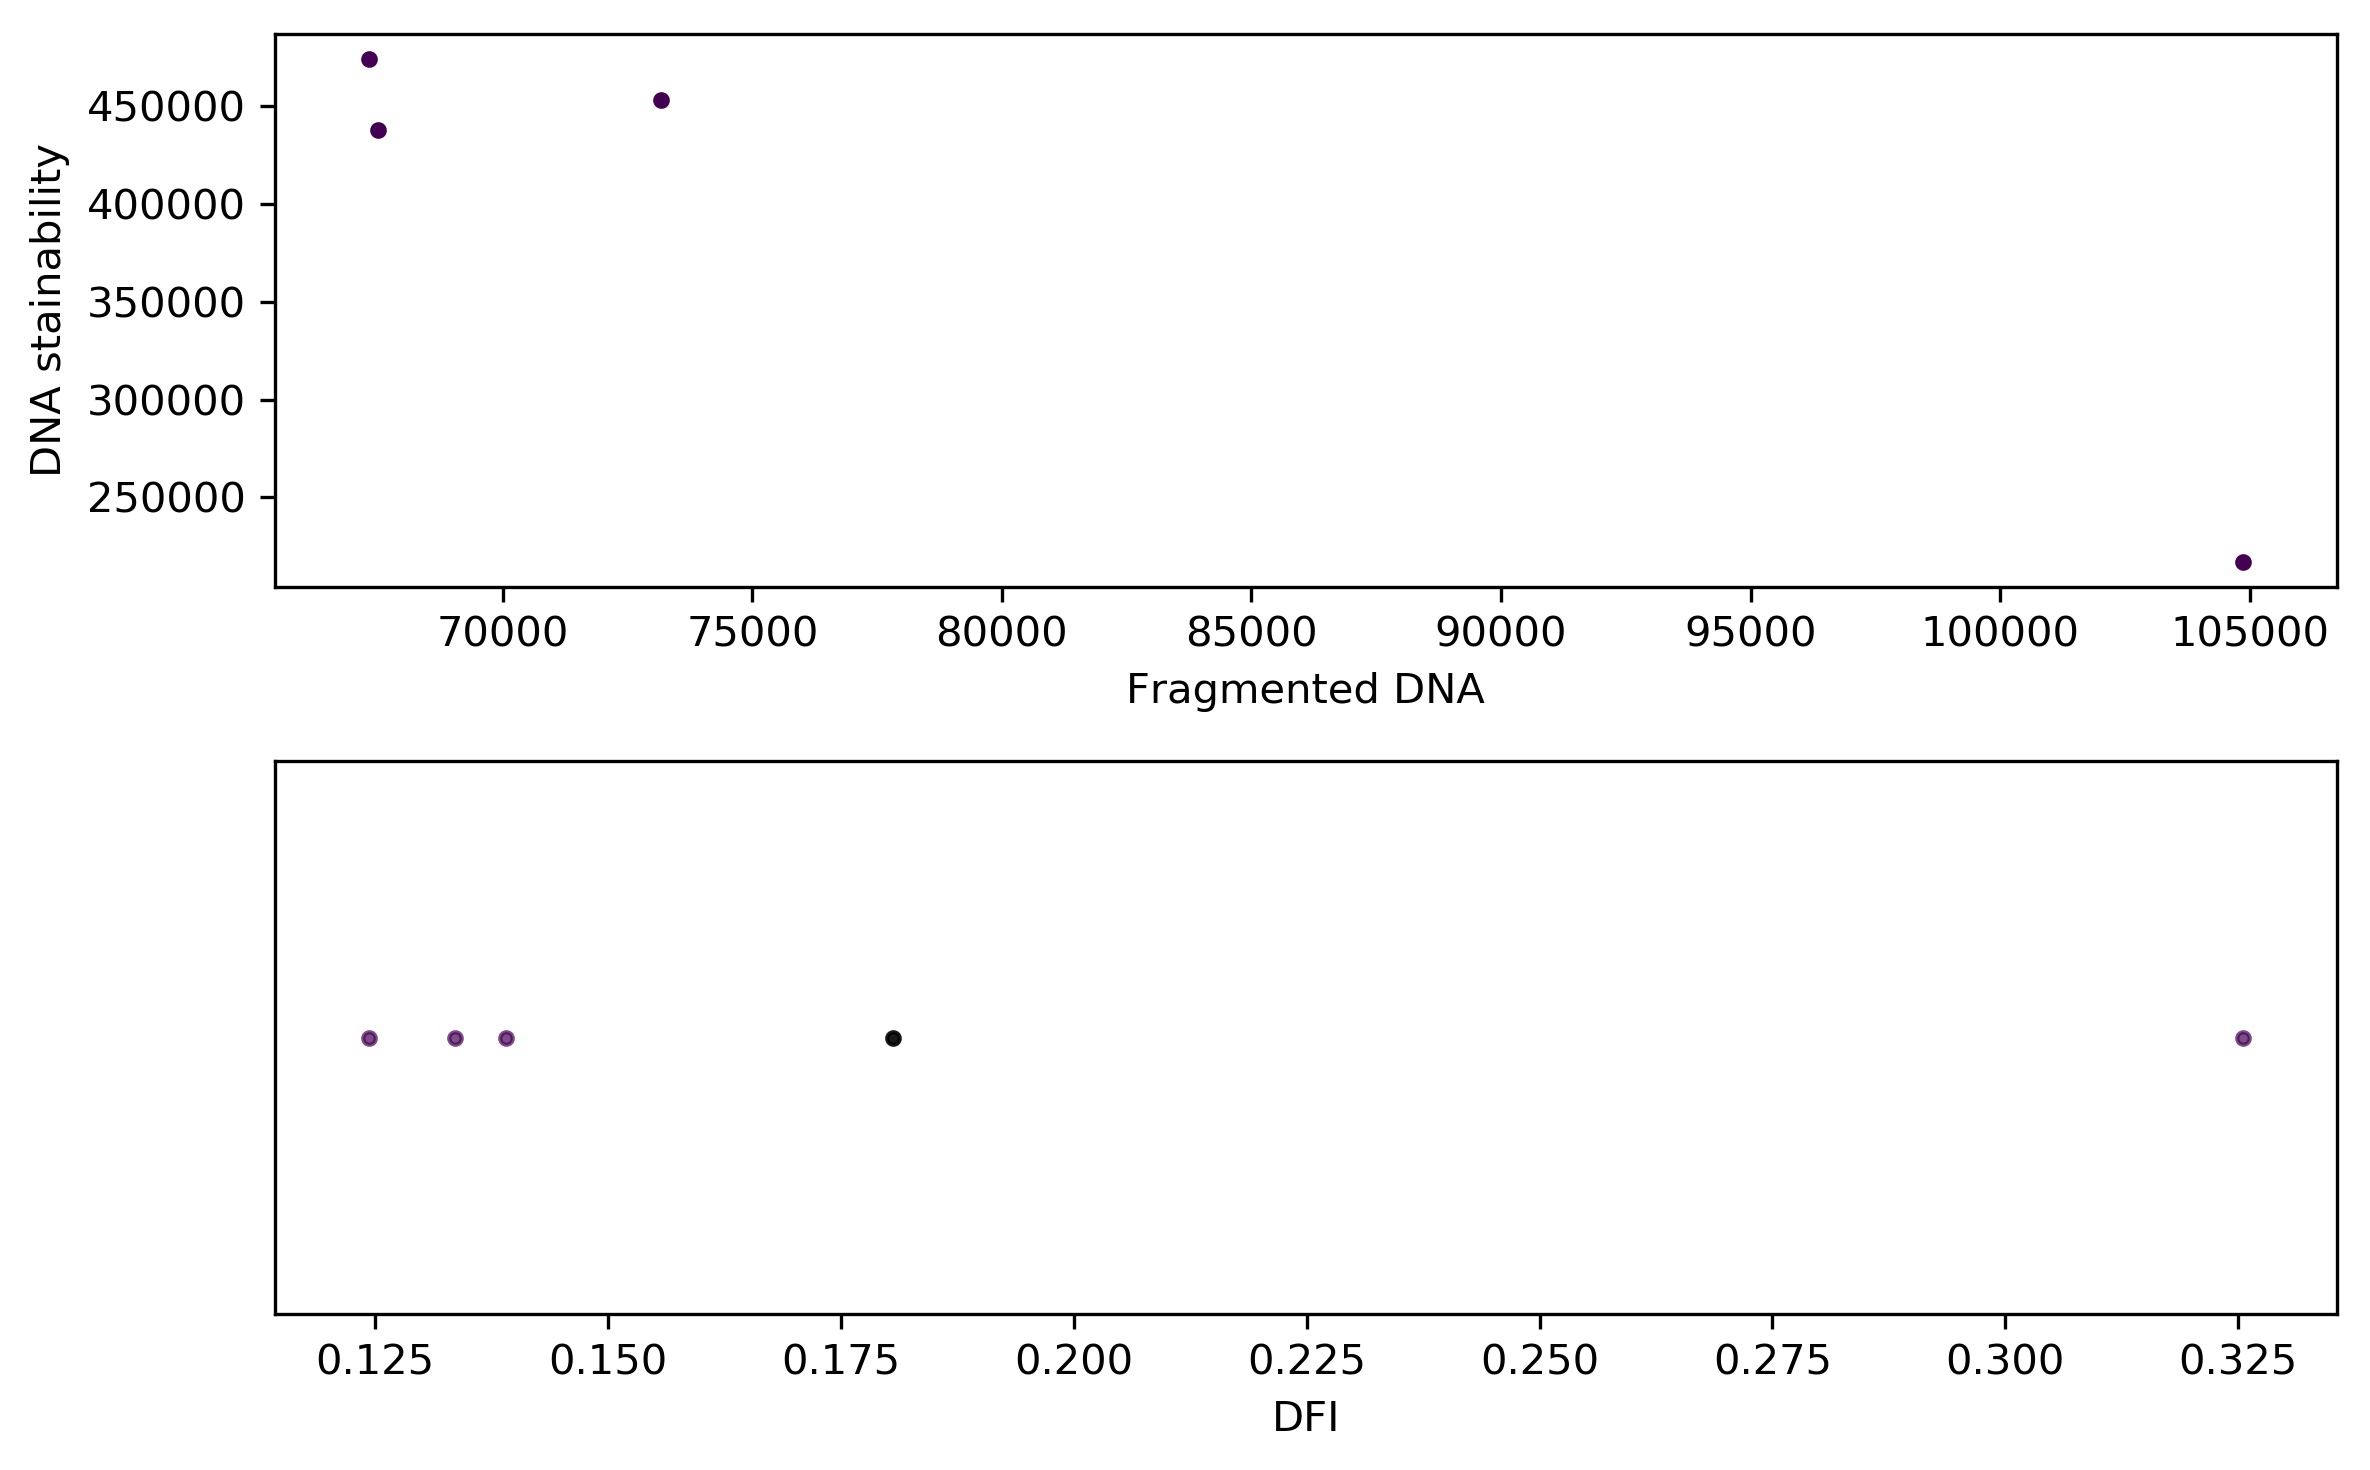

In [11]:
plt.figure(figsize=(8,5),dpi=300)

just_names = np.unique(np.asarray(img_name_list))

n_just_names = len(just_names)

colors = plt.cm.viridis(np.linspace(0,1,n_just_names))
colors2 = colors

for i,name in enumerate(just_names):
    ax = plt.subplot(2,1,1)
    
    temp_good = [good_list[i] for i,img_name in enumerate(img_name_list) if img_name==name]
    temp_bad = [bad_list[i] for i,img_name in enumerate(img_name_list) if img_name==name]
    
#     print('name = %s, n_inds = %s' % (name, len(inds)))
    plt.plot(temp_bad, temp_good, '.', c=colors2[i,:3])
#     plt.plot(bad_list[inds], good_list[inds], '.', c=colors2[i,:3])

    plt.xlabel('Fragmented DNA')
    plt.ylabel('DNA stainability')
    
    ax2 = plt.subplot(2,1,2)
    
    temp_DFI = [DFI_list[i] for i,img_name in enumerate(img_name_list) if img_name==name]

    plt.plot(temp_DFI, 2*i/n_just_names*np.ones_like(temp_DFI), 
             '.', c=colors2[i,:3],alpha=0.7)
    plt.plot(np.mean(temp_DFI), 2*i/n_just_names,'.',c='k',alpha=0.9)
    plt.xlabel('DFI')
    ax2.set_yticks([])
    
plt.tight_layout()
plt.show()

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


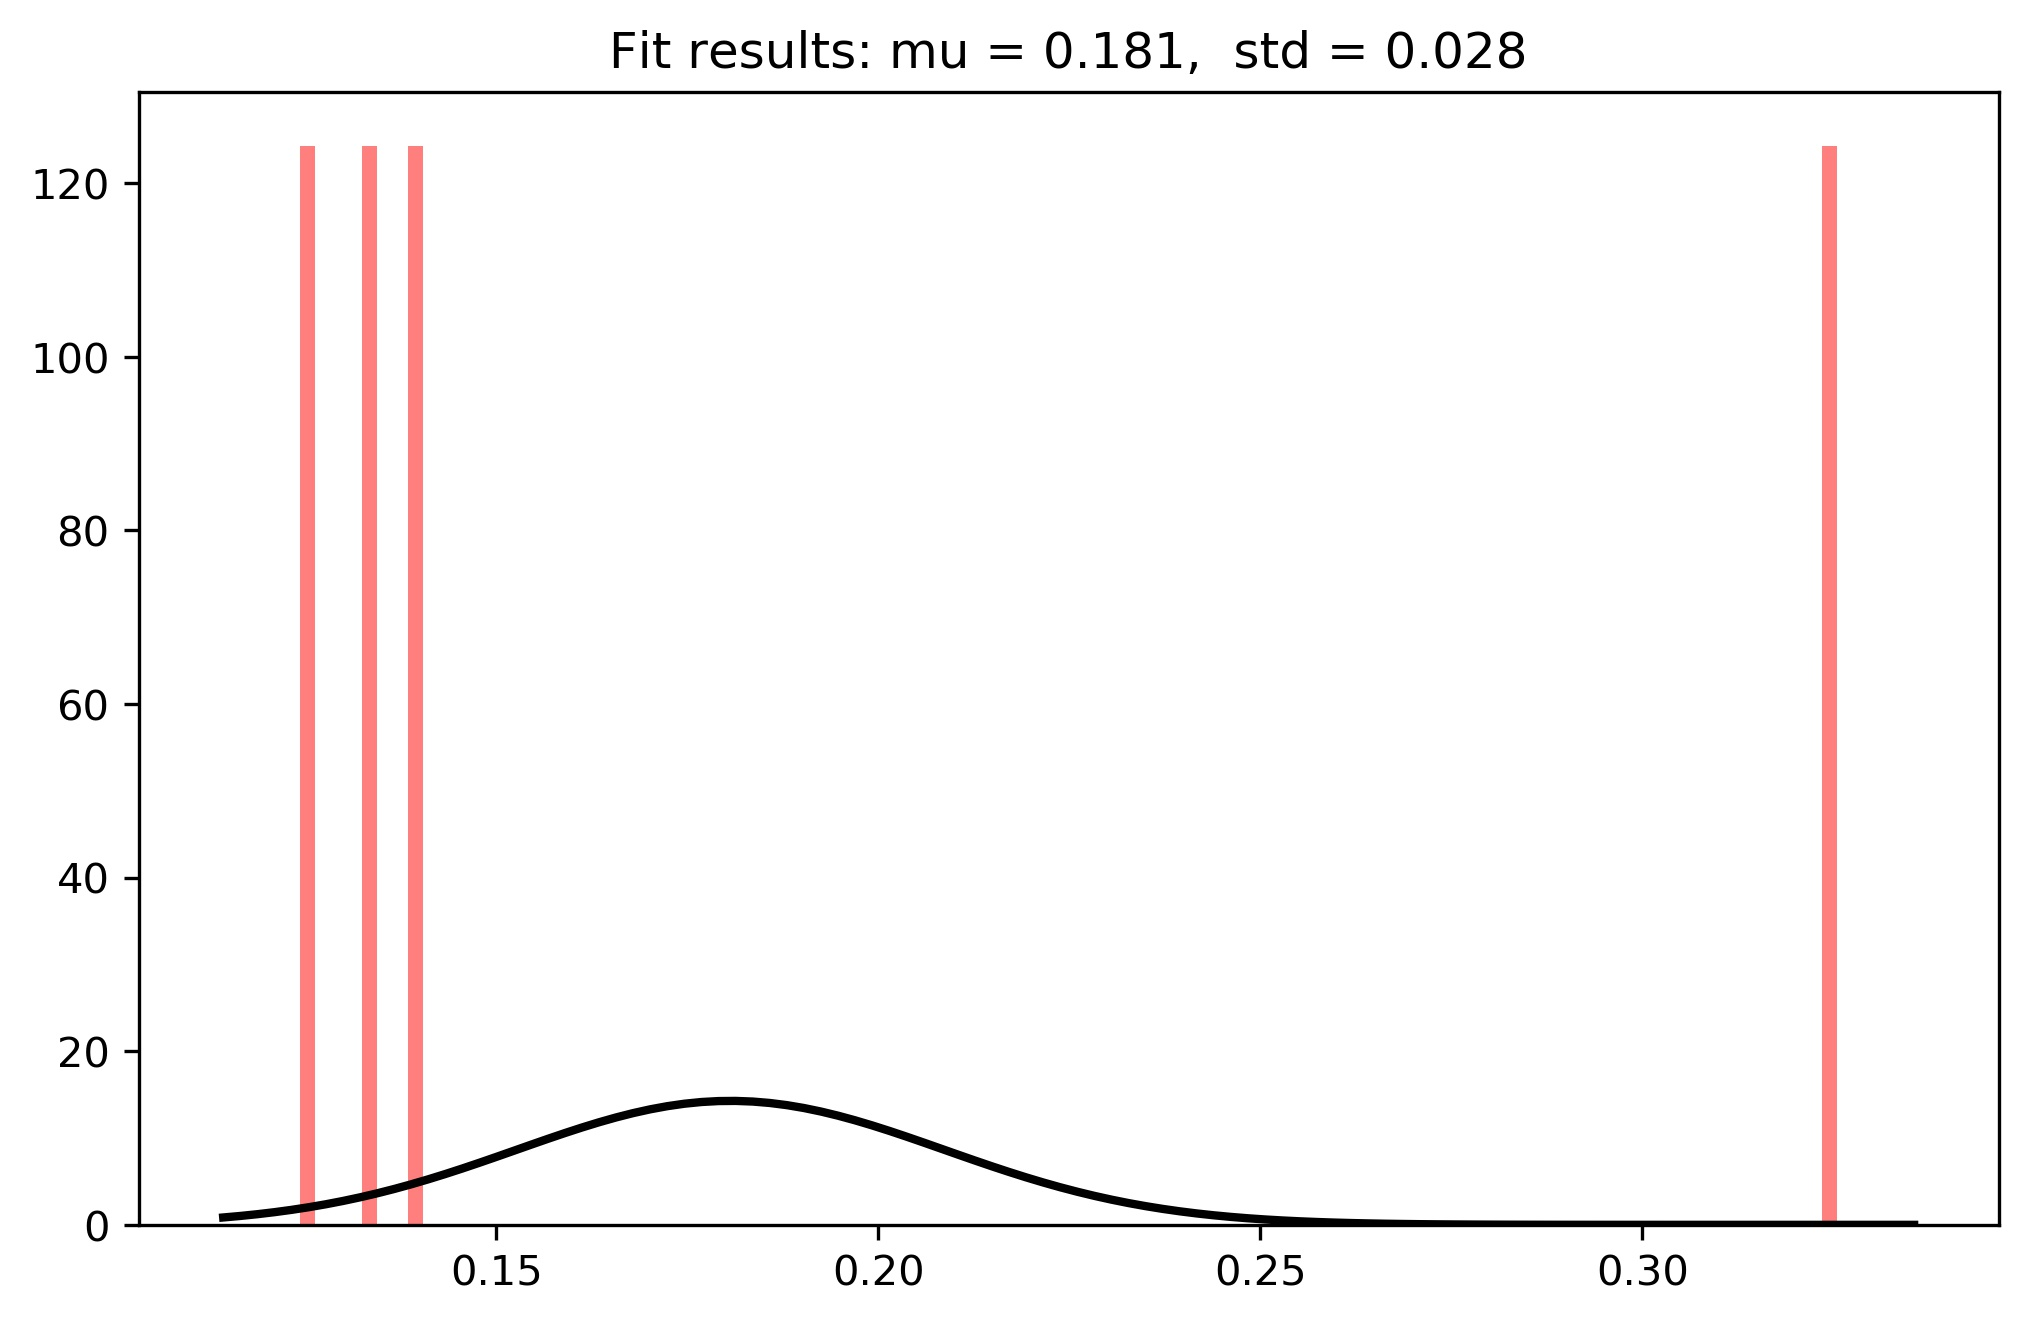

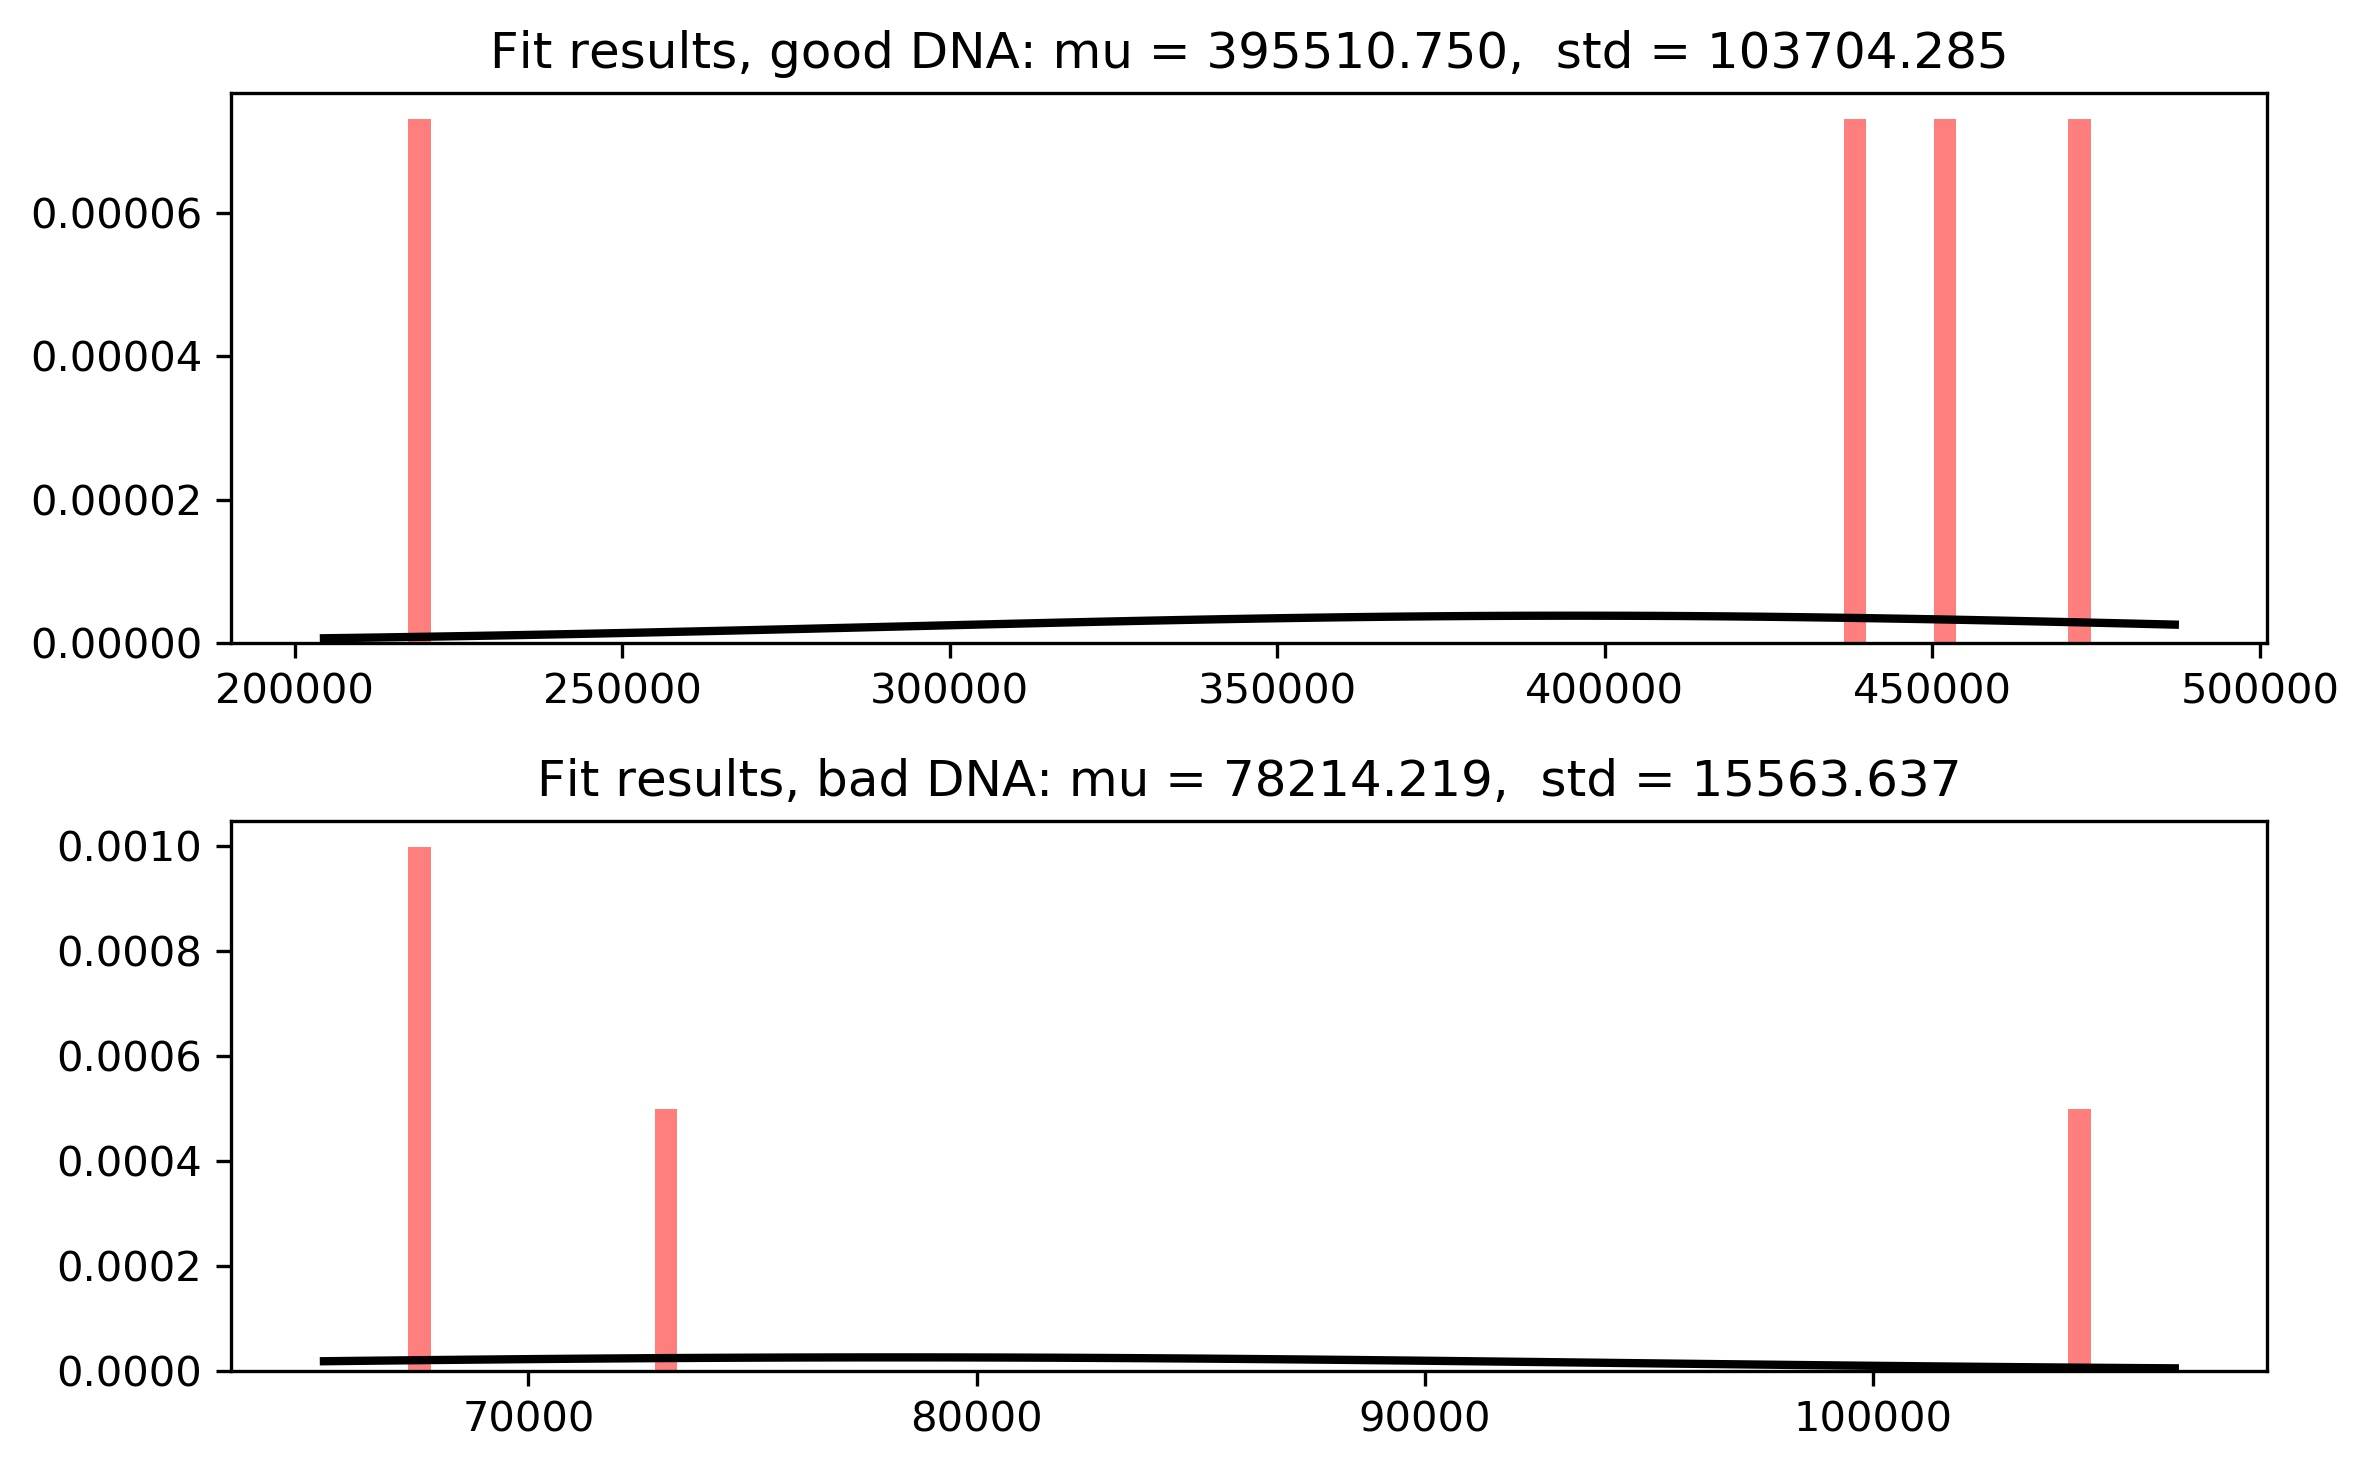

In [12]:
from scipy.stats import norm
                
## manually look to see which images might be bad
# create list of image numbers
bad_DFIs = []

# look at DFI values to see if we should ignore some more
plt.figure(figsize=(8,5),dpi=300)
mu, std = norm.fit(DFI_list)
std = std/3
plt.hist(DFI_list, bins=100, normed=True, alpha=0.5, color='r')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.3f,  std = %.3f" % (mu, std)
plt.title(title)
plt.show()

# look at good/bad values to see if we should ignore some more
plt.figure(figsize=(8,5),dpi=300)
mu, std = norm.fit(good_list)

plt.subplot(2,1,1)
plt.hist(good_list, bins=75, normed=True, alpha=0.5, color='r')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results, good DNA: mu = %.3f,  std = %.3f" % (mu, std)
plt.title(title)

plt.subplot(2,1,2)
mu, std = norm.fit(bad_list)
plt.hist(bad_list, bins=75, normed=True, alpha=0.5, color='r')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results, bad DNA: mu = %.3f,  std = %.3f" % (mu, std)
plt.title(title)

plt.tight_layout()
plt.show()

In [17]:
new_bad_DFIs = np.argwhere((np.asarray(DFI_list)<0.02) | (np.asarray(DFI_list)>.5))
new_bad_goods = np.argwhere((np.asarray(good_list)<50000) | (np.asarray(good_list)>750000))
new_bad_bads = np.argwhere((np.asarray(bad_list)<5000) | (np.asarray(bad_list)>125000))

new_bad_inds0 = new_bad_DFIs[:,0].tolist() + new_bad_goods[:,0].tolist() + \
                new_bad_bads[:,0].tolist() + bad_DFIs

new_bad_inds = np.unique(new_bad_inds0)

print('%s images to ignore for reasons... ' % len(np.unique(new_bad_inds)))

0 images to ignore for reasons... 


In [18]:
print('orig num images = %s' % len(DFI_list))
all_image_nums = np.arange(len(DFI_list))
good_image_nums = np.delete(all_image_nums,new_bad_inds)

final_DFI_list = np.delete(np.asarray(DFI_list),new_bad_inds)
final_bad_list = np.delete(np.asarray(bad_list),new_bad_inds)
final_good_list = np.delete(np.asarray(good_list),new_bad_inds)
final_img_name_list = np.delete(np.asarray(img_name_list),new_bad_inds)

print('output num images = %s' % len(final_DFI_list))

dict_DFI = {}
dict_DFI['good'] = final_good_list
dict_DFI['bad'] = final_bad_list
dict_DFI['DFI'] =  final_DFI_list
dict_DFI['zimg_name'] =  final_img_name_list

orig num images = 4
output num images = 4


c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  """
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  import sys
c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: using a non-integer array as obj in delete will resu

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


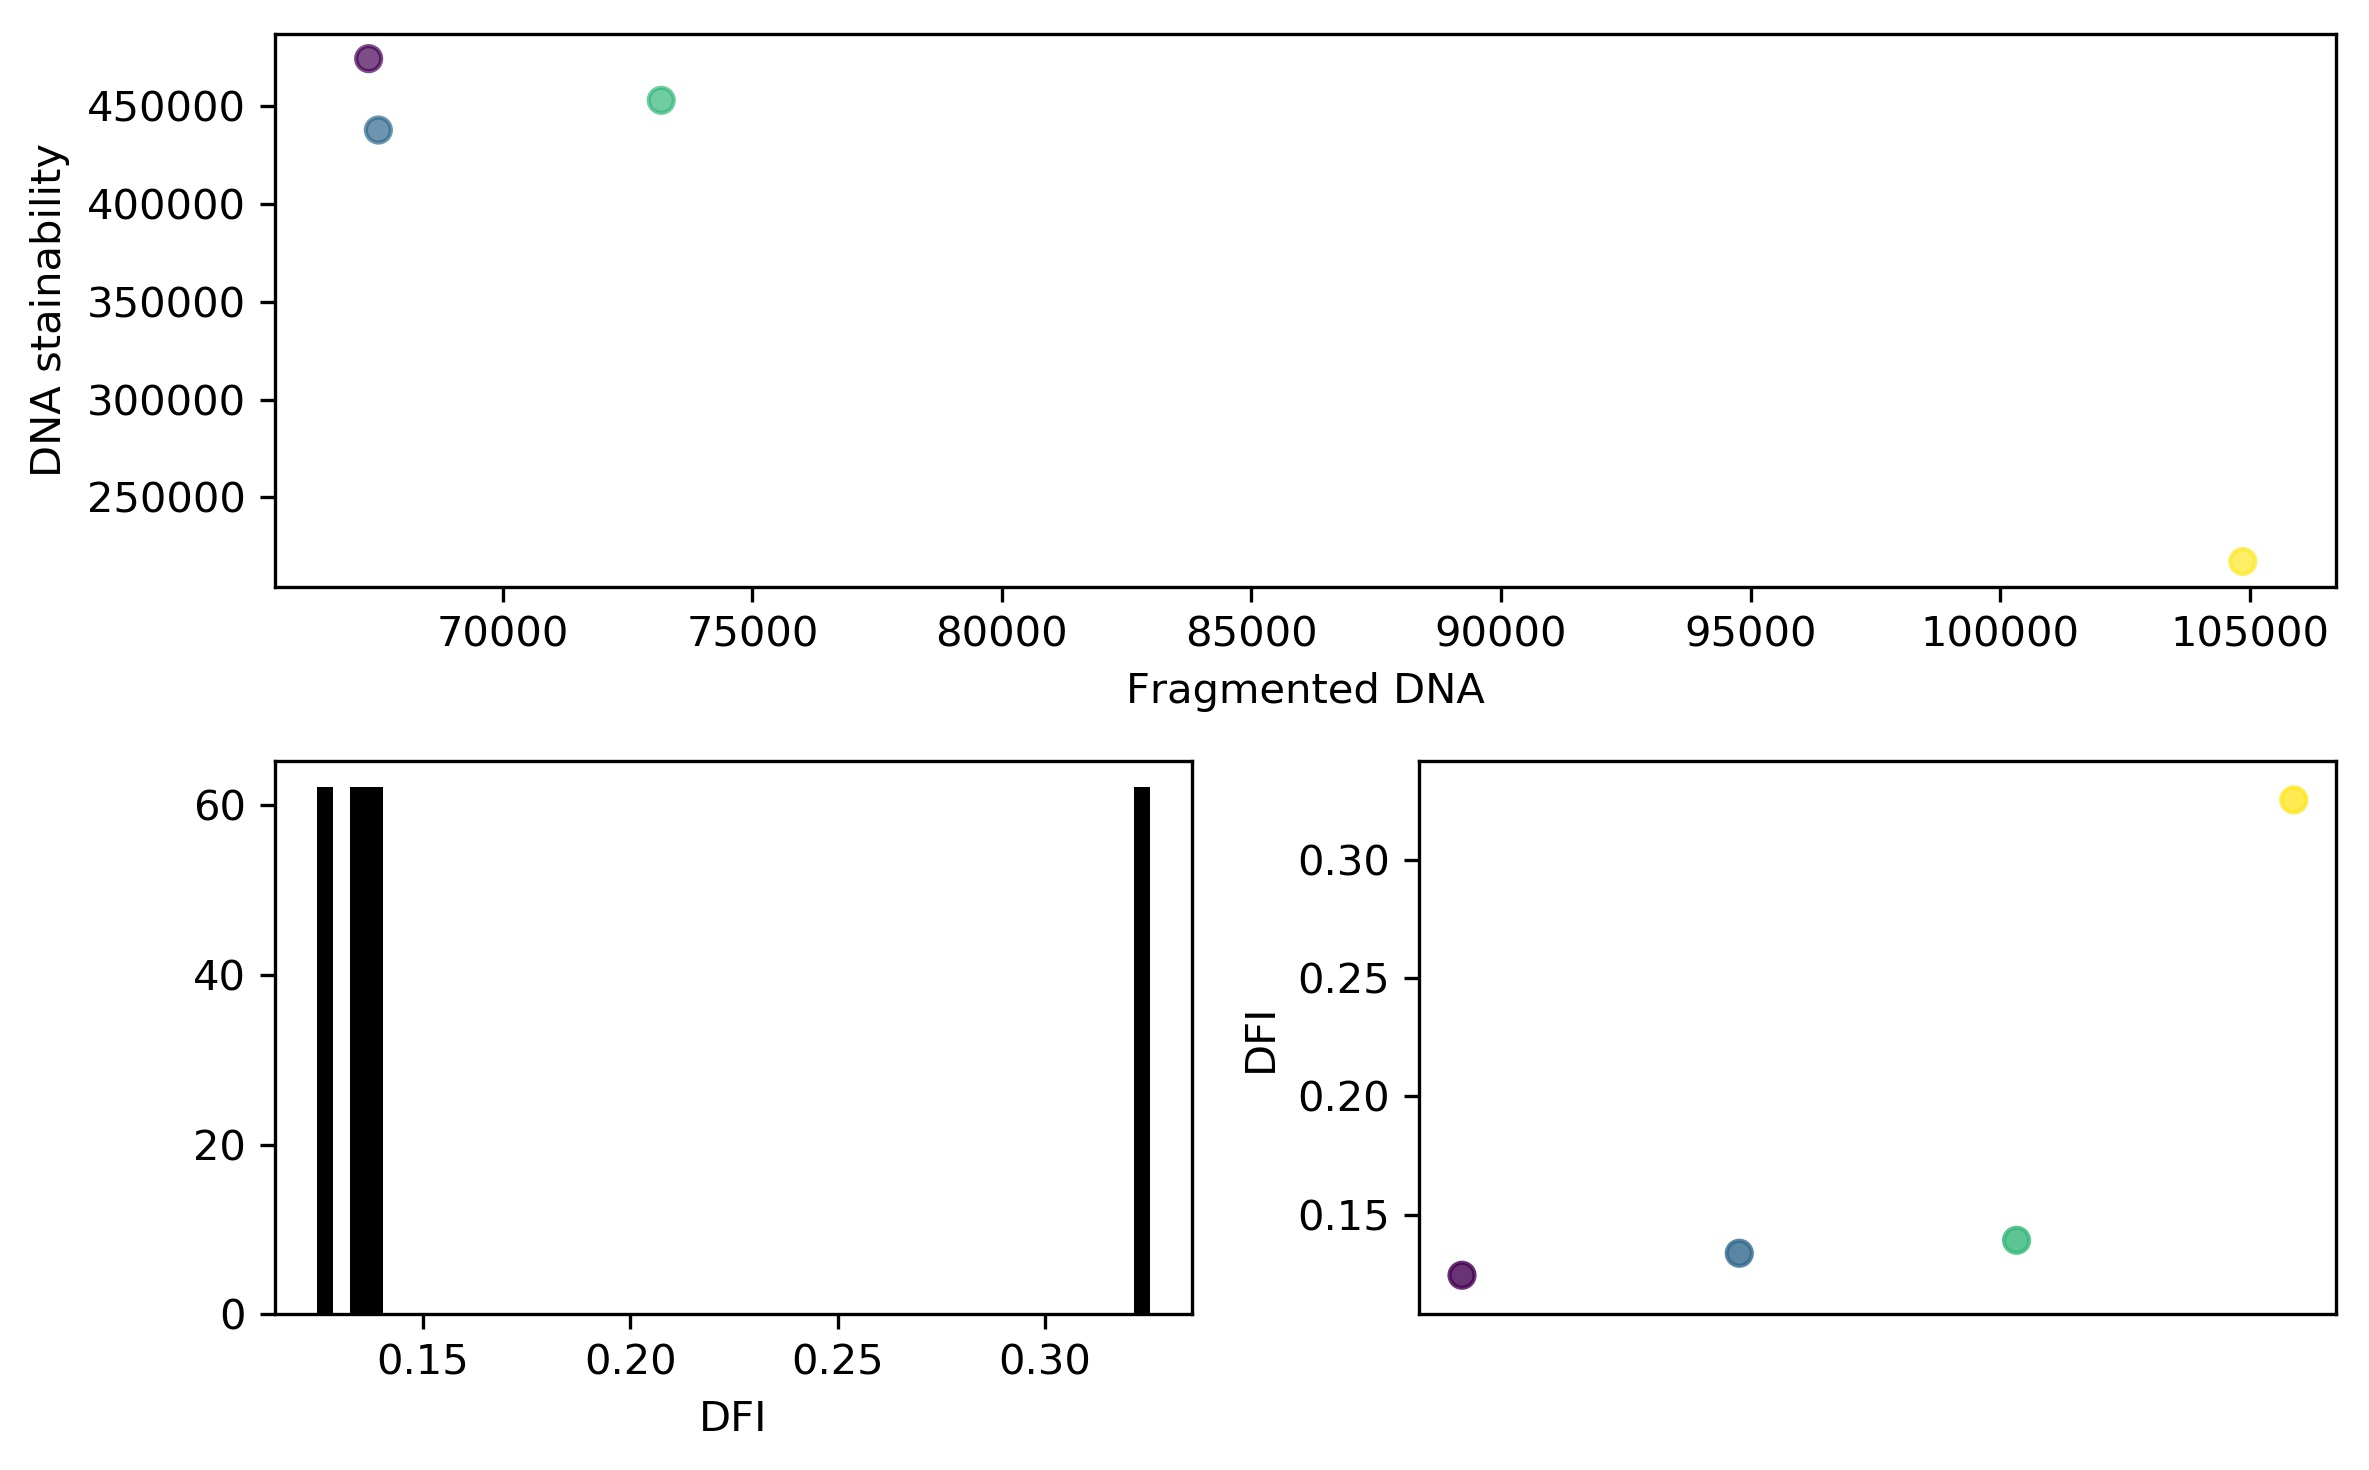

In [19]:
plt.figure(figsize=(8,5),dpi=300)


cmap = plt.cm.get_cmap('viridis')

N = len(final_DFI_list)

colors = cmap(np.linspace(0,1,N))

DFI_inds = np.argsort(final_DFI_list)

plt.subplot(2,1,1)
# plt.plot(final_bad_list, final_good_list, '.k')
plt.scatter(final_bad_list[DFI_inds], final_good_list[DFI_inds], 
            c=colors, alpha=0.7)

plt.xlabel('Fragmented DNA')
plt.ylabel('DNA stainability')

plt.subplot(2,2,3)
plt.hist(final_DFI_list, bins=50, normed=True, alpha=1, color='k')
plt.xlabel('DFI')

plt.subplot(2,2,4)
plt.scatter(np.arange(N),final_DFI_list[DFI_inds], alpha=0.8, c=colors)
plt.ylabel('DFI')
plt.gca().set_xticks([])

plt.tight_layout()

plt.show()

In [20]:
if make_imgs:
    df_DFI = pd.DataFrame.from_dict(dict_DFI)
    df_DFI.to_csv(os.path.join(path_write_good, 'DFIs.csv'))

    img_nums_str = ['%03d' % (i) + '_BF' for i in good_image_nums]
    all_good_image_files = [f for f in os.listdir(path_write) \
                         if any(f2 in f for f2 in img_nums_str)] # (os.path.join(path_write,f)) in img_nums_str
    # print(img_nums_str)
    # print(all_good_image_files)

    big_iter = 0
    for img_name in all_good_image_files:
        new_num = '%03d' % (big_iter)
        new_img_name = 'img' + new_num + img_name[6:]
        src = os.path.join(path_write,img_name)
        dst = os.path.join(path_write_good,new_img_name)

        copyfile(src,dst)
        big_iter += 1